# PROJET TC4 - HMM ordre 1 & 2

Participant: Théo Cornille - theocornille3@gmail.com

**Le but de ce projet est de construire un modèle de markov d'ordre 1 et 2 pour corriger la typographie dans les textes.**

In [85]:
import pickle

with open(r'C:\Users\TCO\Desktop\TC4P\train10.pkl', 'rb') as f:
    train10 = pickle.load(f)
with open(r'C:\Users\TCO\Desktop\TC4P\test10.pkl', 'rb') as f:
    test10 = pickle.load(f)
with open(r'C:\Users\TCO\Desktop\TC4P\train20.pkl', 'rb') as f:
    train20 = pickle.load(f)
with open(r'C:\Users\TCO\Desktop\TC4P\test20.pkl', 'rb') as f:
    test20 = pickle.load(f)

In [2]:
print("Nombre de mots dans train10 = "+str(len(train10)))
print("Nombre de mots dans test10  = "+str(len(test10)))
print("Nombre de mots dans train20 = "+str(len(train20)))
print("Nombre de mots dans test20  = "+str(len(test20)))

Nombre de mots dans train10 = 29057
Nombre de mots dans test10  = 1501
Nombre de mots dans train20 = 27184
Nombre de mots dans test20  = 3374


**Lecture du texte original 'Unmanifesto':**

In [87]:
#read the text
text=''
for word in train10:
    for letter in word:
        text+=str(letter[1])
    text+=' '
print('Texte original:')
print(text)

Texte original:
by their own account violence is for them a form of liberation in other words by committing violence they break through the psychological restraints that have been trained into them because they are oversocialized these restraints have been more confining for them than for others hence their need to break free of them but they usually justify their rebellion in terms of mainstream values if they engage in violence they claim to be fighting against racism or the like we realize that many objections could be raised to the foregoing thumb nail sketch of leftist psychology the real situation is complex and anything like a complete description of it would take several volumes even if the necessary data were available we claim only to have indicated very roughly the two most important tendencies in the psychology of modern leftism the problems of the leftist are indicative of the problems of our society as a whole low self esteem depressive tendencies and defeatism are not re

**Lecture du texte bruité à 10% :**

In [4]:
text=''
for word in test10:
    for letter in word:
        text+=str(letter[0])
    text+=' '
print('Texte bruité:')
print(text)

Texte bruité:
the leftist is too far gone for that his reeljhgs of inferikrigy are sl ingrzined that he cannot conceive of hkmsekf ad individually strkng and vakhavle hence tnr cillectivism of yhe leftist he can feel strong ojly ss s membee of a karge prganization or q mass movejrnt with which he idenyifies himself notice the maaochistic tendency of leftist tsctics lertusts pfoyesr ny lying cosn in rront ot vehicles they intenrionally provokr police or racists tl abhse them etc theze tactixs may often be effectuve bur mamy leftists usr them not as a meqns to aj end but because tney prefer masochixtic yaftica self hatrdd is a leftisg trait peftists nay claim that yyeir actkvism is motivated by compassion or by motao principle and moral peihciple does play a role for ghe leftist of the ofersocialkzed type but comoassion and moral principle cannot be thd jain motives for pwfrixt activism hostility is toi prominebt a component of leftist behavior so ia thr xrive foe power moreovdr mudh lef

### Classe HMM 

In [5]:
import numpy as np
import sys
import operator
import math

class HMM:
        def __init__(self, state_list, observation_list, transition_proba = None, observation_proba = None, initial_state_proba = None, transition_head_proba= None, order=1):
            
            self.order=order
            
            """Builds a new Hidden Markov Model
            state_list is the list of state symbols [q_0...q_(N-1)]
            observation_list is the list of observation symbols [v_0...v_(M-1)]
            transition_proba is the transition probability matrix
                [a_ij] a_ij = Pr(Y_(t+1)=q_i|Y_t=q_j)
            observation_proba is the observation probablility matrix
                [b_ki] b_ki = Pr(X_t=v_k|Y_t=q_i)
            initial_state_proba is the initial state distribution
                [pi_i] pi_i = Pr(Y_0=q_i)"""
            print("HMM creating with: ")
            self.N = len(state_list) # The number of states
            self.M = len(observation_list) # The number of observations
            print(str(self.N)+" states")
            print(str(self.M)+" observations")
            self.omega_Y = state_list # Keep the alphabet of correct letters
            self.omega_X = observation_list # Keep the alphabet of actual letters
            # Init. of the 3 distributions : observation, transition and initial states
            if self.order==2:
                if transition_head_proba is None:
                    self.transition_head_proba = np.zeros( (self.N, self.N), float) 
                else:
                    self.transition_head_proba=transition_head_proba
            
            if transition_proba is None:
                if self.order==1:
                    self.transition_proba=np.zeros((self.N, self.N), float)
                if self.order==2:
                    self.transition_proba=np.zeros((self.N, self.N, self.N), float)
            else:
                self.transition_proba=transition_proba  
            
            if observation_proba is None:
                self.observation_proba = np.zeros((self.M, self.N), float) 
            else:
                self.observation_proba=observation_proba  
                
            if initial_state_proba is None:
                    self.initial_state_proba = np.zeros((self.N,), float)  
            else:
                self.initial_state_proba=initial_state_proba
                
            self.make_indexes()
            
            self.Y_inv_map = {v: letter for letter, v in self.Y_index.items()}
            

        def make_indexes(self):
            """Creates the reverse table that maps states/observations names
            to their index in the probabilities arrays"""
            self.Y_index = {}
            for i in range(self.N):
                self.Y_index[self.omega_Y[i]] = i
            self.X_index = {}
            for i in range(self.M):
                self.X_index[self.omega_X[i]] = i
            
            
        def observation_estimation(self, cpairs):
            """ Build the observation distribution: 
                observation_proba is the observation probablility matrix
                [b_ki],  b_ki = Pr(X_t=v_k|Y_t=q_i)"""
            # fill with counts
            for pair in cpairs:
                observation=pair[0]
                state=pair[1]
                k = 0 # for <unk>
                if observation in self.X_index: 
                    k=self.X_index[observation]
                    j=self.Y_index[state]
                    self.observation_proba[k,j]=cpairs[pair]
            # normalize
            self.observation_proba=self.observation_proba/self.observation_proba.sum(axis=0)
        
        def transition_estimation(self, ctrans):
            if self.order==1:
                """ Build the transition distribution: 
                    transition_proba is the transition matrix with : 
                    [a_ij] a[i,j] = Pr(Y_(t+1)=q_i|Y_t=q_j)"""
                # fill with counts
                for pair in ctrans:
                    i=self.Y_index[pair[0]]
                    j=self.Y_index[pair[1]]
                    self.transition_proba[i,j]=ctrans[pair]
                # normalize
                self.transition_proba=self.transition_proba/self.transition_proba.sum(axis=0)
            
            if self.order==2:
                """ Build the transition distribution: 
                transition_proba is the transition matrix with : 
                [a_ij] a[i,j] = Pr(Y_(t+1)=q_i|Y_t=q_j,Y_(t-1)=q_k)
                """
                # fill with counts
                for triple in ctrans:
                    i=self.Y_index[triple[2]]
                    j=self.Y_index[triple[1]]
                    k=self.Y_index[triple[0]]
                    self.transition_proba[k,j,i]=ctrans[triple]
                #normalize
                self.transition_proba = self.transition_proba + 0.01
                self.transition_proba=self.transition_proba/self.transition_proba.sum(axis=(1,2))
                #self.transition_proba = np.nan_to_num(self.transition_proba)
        
        #only for order 2
        def transition_head_estimation(self, trans_heads_counts):
        # fill with counts
            ctrans_head=trans_heads_counts[0]
            for pair in ctrans_head:
                    j = self.Y_index[pair[1]]
                    k = self.Y_index[pair[0]]
                    self.transition_head_proba[k, j] = ctrans_head[pair]
            self.transition_head_proba = self.transition_head_proba + 0.01
            self.transition_head_proba = self.transition_head_proba / self.transition_head_proba.sum(axis=0)
            #self.transition_head_proba = np.nan_to_num(self.transition_head_proba)

            
        def init_estimation(self, cinits):
            """Build the init. distribution"""
            # fill with counts
            for state in cinits:
                i=self.Y_index[state]
                self.initial_state_proba[i]=cinits[state]
            # normalize
            self.initial_state_proba=self.initial_state_proba/np.sum(self.initial_state_proba)
        
                
        def supervised_training(self, cpairs, ctrans ,cinits, *ctrans_head):
            """Train the HMM's parameters. This function wraps everything"""
            self.observation_estimation(cpairs)
            self.transition_estimation(ctrans)
            self.init_estimation(cinits)
            if self.order==2:
                self.transition_head_estimation(ctrans_head)
                
                
        def make_counts(self, corpus):
            """
            Build different count tables to train a HMM_1 & 2. Each count table is a dictionnary.
            Returns:
            * c_letterObs: No correct Letter Count (Observation letters)
            * c_letterState:  Correct Letters (State letters)
            * c_pairs: count of pairs 
            * c_transitions: count of tag 3-gram
            * c_inits: count of 2-gram found in the first and second position
            """
            c_letterObs = dict()
            c_letterState = dict()
            c_pairs = dict()
            c_transitions = dict()
            ctrans_head = dict()
            c_inits = dict()
            for word in corpus:
                # we use i because of the transition counts
                for i in range(len(word)):
                    couple = word[i]
                    letter = couple[0]
                    tag = couple[1]
                    # word counts
                    if letter in c_letterObs:
                        c_letterObs[letter]+= 1
                    else:
                        c_letterObs[letter] = 1
                    # tag counts
                    if tag in c_letterState:
                        c_letterState[tag]+= 1
                    else:
                        c_letterState[tag] = 1

                    if self.order==1:
                        if i > 0:
                            #transition counts
                            trans = (word[i-1][1], tag)
                            if trans in c_transitions:
                                c_transitions[trans]+=1
                            else:
                                c_transitions[trans]=1

                    if self.order==2:
                        if i > 1:
                            #transition counts
                            trans = (word[i - 2][1], word[i - 1][1], tag)
                            if trans in c_transitions:
                                c_transitions[trans]+= 1
                            else:
                                c_transitions[trans] = 1
                        if i == 1:
                            z = (word[i-1][1], tag)
                            if z in ctrans_head:
                                ctrans_head[z]+= 1
                            else:
                                ctrans_head[z] = 1

                    if i == 0:
                        # init counts, i == 0 -> counts for initial states
                        z = tag
                        if z in c_inits:
                            c_inits[z]+= 1
                        else:
                            c_inits[z] = 1
                    # observation counts
                    o = (letter, tag)
                    if o in c_pairs:
                        c_pairs[o]+= 1
                    else:
                        c_pairs[o] = 1
            
            if self.order==1:
                return c_letterObs, c_letterState, c_pairs, c_transitions, c_inits
            if self.order==2:
                return c_letterObs, c_letterState, c_pairs, c_transitions, ctrans_head, c_inits

        
        
        
        def run_viterbi(self, word):
            T = len(word)
            
            if self.order==1:
                T1 = np.empty((self.N, T))
                T2 = np.empty((self.N, T))
                # Initilaize the tracking tables from first observation
                
                idx0 = self.X_index[word[0][0]]
                
                T1[:, 0] = self.initial_state_proba.T * self.observation_proba[idx0, :].T
                T2[:, 0] = 0

                # Iterate throught the observations updating the tracking tables
                for t in range(1, T):
                    idx = self.X_index[word[t][0]]
                    for s in range(self.N):
                        trans_p = T1[:, t - 1] * self.transition_proba[:,s]
                        T2[s,t], T1[s,t] = max(enumerate(trans_p), key=operator.itemgetter(1))
                        T1[s,t] = T1[s,t]*self.observation_proba[idx,s].T

                best_path = np.zeros(T)
                best_path[T-1] =  T1[:,T-1].argmax() # last state
                for t in range(T-1,0,-1): # states of (last-1)th to 0th time step
                    best_path[t-1] = T2[int(best_path[t]),t]

                return best_path
        
            if self.order==2:
                if T<2:
                    return [self.Y_index[z[0]] for z in word]
                else:
                    T1 = np.zeros((self.N, self.N, T)) # initialise viterbi table
                    T1_prime = np.zeros((self.N,T)) # initialise viterbi table
                    T2 = np.zeros((self.N, self.N, T)) # initialise the best path table

                    idx0 = self.X_index[word[0][0]]
                    idx1 = self.X_index[word[1][0]]

                    T1_prime[:,0] = self.initial_state_proba.T * self.observation_proba[idx0,:].T
                    T2[:, 0] = 0

                    for s in range (0,self.N): # loop through the states @(t-2)
                        for v in range (0,self.N): # loop through the states @(t-1)
                            T1[s,v,1] = T1_prime[s,0] * self.transition_head_proba[s,v] * self.observation_proba[idx1,v]


                    for t in range(2,T): # loop through time
                        idx = self.X_index[word[t][0]]
                        for s in range (0,self.N): # loop through the states @(t-1)
                            for v in range (0,self.N): # loop through the states @(t-1)
                                trans_p = T1[:,s,t-1] * self.transition_proba[:,s,v]
                                
                                if(math.isnan(trans_p[0])):
                                    trans_p[0]=0

                                T2[s,v,t], T1[s,v,t] = max(enumerate(trans_p), key=operator.itemgetter(1))
                                T1[s,v,t] = T1[s,v,t]*self.observation_proba[idx,v].T

                    best_path = np.zeros(T)
                    best_path[T-1] = np.unravel_index(T1[:,:,T-1].argmax(), T1[:,:,T-1].shape)[1]
                    best_path[T-2] = np.unravel_index(T1[:,:,T-1].argmax(), T1[:,:,T-1].shape)[0]


                    for t in range(T-3,-1,-1): # states of (last-1)th to 0th time step
                        best_path[t] = T2[int(best_path[t+1]),int(best_path[t+2]),t+2]

                    return best_path

        
        def decode_word(self, encoded_word):
            decoded_word=''
            for idx in encoded_word:
                decoded_word+=str(self.Y_inv_map[idx])
            return decoded_word
        
        def transform_to_word_list(self, data):
            txt=''
            for word in data:
                for letter in word:
                    txt+=str(letter[1])
                txt+=' '
            correct_word_list = txt.split(' ')
            return(correct_word_list)
        
        def get_error_rate_on_word(self, data):
            correct_word_list = self.transform_to_word_list(data)
            error_rate=0
            for key, w in enumerate(data):
                x = self.run_viterbi(w)
                decoded_x = self.decode_word(x)
                
                actual=''
                for l in range(len(w)):
                    actual += str(w[l][0])
                
                if (decoded_x != correct_word_list[key]):
                    error_rate+=1
            error_rate/=len(data)
            print('error rate on words:',100*error_rate)
        
        def get_error_rate_on_letter(self, data):
            correct_word_list = self.transform_to_word_list(data)
            error_rate=0
            tot=0
            for w in data:
                x = self.run_viterbi(w)
                decoded_x = self.decode_word(x)
                for l in range(len(w)):
                    tot+=1

                    if (str(decoded_x)[l]!=w[l][1]):
                        error_rate+=1
            error_rate/=tot
            print('error rate on letters:',100*error_rate)
            
        def get_initial_error_rate_on_letter(self,data):
            error=0
            tot=0
            for w in data:
                for l in w:
                    if l[0]!=l[1]:
                        error+=1
                    tot+=1
            error_rate=100*(error/tot)
            print('initial error rate on letters:', error_rate)
            
        def get_initial_error_rate_on_word(self,data):
            correct_word_list = self.transform_to_word_list(data)
            error=0
            for w in data:
                actual_word=''
                correct_word=''
                for l in w:
                    actual_word += str(l[0])
                    correct_word += str(l[1])
                if (actual_word != correct_word):
                    error+=1
            error_rate=error/len(data)
            print('initial error rate on words:',100*error_rate)
            
        def show_correction(self, data):
            correct_word_list = self.transform_to_word_list(data)
            error_rate=0
            for key, w in enumerate(data):
                x = self.run_viterbi(w)
                decoded_x = self.decode_word(x)
                
                actual=''
                for l in range(len(w)):
                    actual += str(w[l][0])
                    
                print('actual:{}, decoded:{}, correct:{}'.format(actual, decoded_x, correct_word_list[key]))


*Liste des états:*

In [6]:
import string
alphabet = list(string.ascii_lowercase)
print(alphabet)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


*Création du vocabulaire à partir du corpus:*

In [7]:
def make_vocab(data, threshold):
    """ 
    return a vocabulary by thresholding word counts. 
    inputs: 
    * c_words : a dictionnary that maps word to its counts
    * threshold: count must be >= to the threshold to be included
    
    returns: 
    * a word list
    """
    txt = transform_to_text(data)
    c_dict={}
    for letter in txt:
        if letter in c_dict:
            c_dict[letter]+= 1
        else:
            c_dict[letter]=1
    voc = []
    #voc.append(UNK)
    for letter in c_dict:
        if c_dict[letter] >= threshold:
            voc.append(letter)
    return voc

def transform_to_text(data):
            txt=''
            for word in data:
                for letter in word:
                    txt+=str(letter[1])
                txt+=' '
            return(txt)

In [8]:
vocab=make_vocab(train10, 10)
print(vocab)

['z', 'f', 'v', 'n', 'h', 'o', 'd', 'e', 'j', 'c', 'r', 't', 'a', 'p', 'u', 'b', 'q', 'y', 'x', 's', 'w', 'i', ' ', 'l', 'k', 'g', 'm']


## HMM ORDRE 1

**Résultats sur train10/test10:**

In [9]:
hmm1 = HMM(state_list=alphabet, observation_list=vocab, transition_proba = None, observation_proba = None, initial_state_proba = None, transition_head_proba= None, order=1)

HMM creating with: 
26 states
27 observations


In [10]:
c_letterObs, c_letterState, cpairs, ctrans, cinits = hmm1.make_counts(train10)
print("Nombre de tags : "+str(len(c_letterObs)))
print("Nombre d'états : "+str(len(c_letterState)))
print("Nombre de paires: "+str(len(cpairs)))
print("Nombre de trans : "+str(len(ctrans)))
print("Nombre d'init. : "+str(len(cinits)))
print("Taille du Vocabulaire : "+str(len(vocab)))

Nombre de tags : 26
Nombre d'états : 26
Nombre de paires: 127
Nombre de trans : 403
Nombre d'init. : 25
Taille du Vocabulaire : 27


In [11]:
hmm1.supervised_training(cpairs,ctrans,cinits)

In [12]:
trans, obs , ini = hmm1.transition_proba, hmm1.observation_proba, hmm1.initial_state_proba

In [13]:
word = train10[4]
print(word)

[('v', 'v'), ('i', 'i'), ('o', 'o'), ('l', 'l'), ('e', 'e'), ('n', 'n'), ('c', 'c'), ('e', 'e')]


In [14]:
x = hmm1.run_viterbi(word)
print(x)

[21.  8. 14. 11.  4. 13.  2.  4.]


In [15]:
print(hmm1.decode_word(x))

violence


In [16]:
hmm1.get_initial_error_rate_on_letter(test10)

initial error rate on letters: 10.1775956284153


In [17]:
hmm1.get_error_rate_on_letter(test10)

error rate on letters: 7.418032786885245


In [18]:
hmm1.get_initial_error_rate_on_word(test10)

initial error rate on words: 37.10859427048634


In [19]:
hmm1.get_error_rate_on_word(test10)

error rate on words: 26.915389740173218


In [20]:
hmm1.show_correction(test10)

actual:the, decoded:the, correct:the
actual:leftist, decoded:leftist, correct:leftist
actual:is, decoded:is, correct:is
actual:too, decoded:too, correct:too
actual:far, decoded:far, correct:far
actual:gone, decoded:tone, correct:gone
actual:for, decoded:for, correct:for
actual:that, decoded:that, correct:that
actual:his, decoded:his, correct:his
actual:reeljhgs, decoded:reelings, correct:feelings
actual:of, decoded:of, correct:of
actual:inferikrigy, decoded:inferiorigy, correct:inferiority
actual:are, decoded:are, correct:are
actual:sl, decoded:al, correct:so
actual:ingrzined, decoded:ingrained, correct:ingrained
actual:that, decoded:that, correct:that
actual:he, decoded:he, correct:he
actual:cannot, decoded:cannot, correct:cannot
actual:conceive, decoded:conceive, correct:conceive
actual:of, decoded:of, correct:of
actual:hkmsekf, decoded:homseof, correct:himself
actual:ad, decoded:ad, correct:as
actual:individually, decoded:individually, correct:individually
actual:strkng, decoded:str

actual:would, decoded:would, correct:would
actual:not, decoded:not, correct:not
actual:satisfy, decoded:satisty, correct:satisfy
actual:their, decoded:their, correct:their
actual:empyiomap, decoded:emptiomap, correct:emotional
actual:nreds, decoded:nteds, correct:needs
actual:helping, decoded:helling, correct:helping
actual:black, decoded:black, correct:black
actual:peoplr, decoded:peoppr, correct:people
actual:is, decoded:is, correct:is
actual:not, decoded:not, correct:not
actual:tjeir, decoded:their, correct:their
actual:deal, decoded:deal, correct:real
actual:voal, decoded:voal, correct:goal
actual:instead, decoded:instead, correct:instead
actual:eace, decoded:eace, correct:race
actual:problems, decoded:problems, correct:problems
actual:serve, decoded:serve, correct:serve
actual:as, decoded:as, correct:as
actual:an, decoded:an, correct:an
actual:excuse, decoded:excuse, correct:excuse
actual:for, decoded:for, correct:for
actual:them, decoded:them, correct:them
actual:to, decoded:to, 

actual:thzn, decoded:than, correct:than
actual:are, decoded:are, correct:are
actual:those, decoded:those, correct:those
actual:of, decoded:of, correct:of
actual:rhe, decoded:the, correct:the
actual:lugytly, decoded:lugytly, correct:lightly
actual:socialized, decoded:socialized, correct:socialized
actual:prrson, decoded:preson, correct:person
actual:the, decoded:the, correct:the
actual:majority, decoded:majority, correct:majority
actual:of, decoded:of, correct:of
actual:people, decoded:people, correct:people
actual:ebgage, decoded:engage, correct:engage
actual:in, decoded:in, correct:in
actual:a, decoded:a, correct:a
actual:skgnififant, decoded:sognififant, correct:significant
actual:amount, decoded:amount, correct:amount
actual:of, decoded:of, correct:of
actual:naughty, decoded:naughty, correct:naughty
actual:bejavior, decoded:bemavior, correct:behavior
actual:thru, decoded:thru, correct:they
actual:lie, decoded:lie, correct:lie
actual:tjwy, decoded:they, correct:they
actual:xommiy, de

actual:expfession, decoded:expression, correct:expression
actual:kindness, decoded:lindness, correct:kindness
actual:to, decoded:to, correct:to
actual:animals, decoded:animals, correct:animals
actual:moee, decoded:more, correct:more
actual:fundamebtalky, decoded:fundamentally, correct:fundamentally
actual:the, decoded:the, correct:the
actual:dhty, decoded:duty, correct:duty
actual:of, decoded:of, correct:of
actual:ghe, decoded:the, correct:the
actual:indivisual, decoded:indivisual, correct:individual
actual:to, decoded:to, correct:to
actual:serfe, decoded:serfe, correct:serve
actual:society, decoded:society, correct:society
actual:amd, decoded:and, correct:and
actual:thd, decoded:the, correct:the
actual:dhty, decoded:duty, correct:duty
actual:kf, decoded:of, correct:of
actual:wociety, decoded:wociety, correct:society
actual:to, decoded:to, correct:to
actual:tsle, decoded:tale, correct:take
actual:csre, decoded:care, correct:care
actual:of, decoded:of, correct:of
actual:the, decoded:the

actual:that, decoded:that, correct:that
actual:bpsck, decoded:blsck, correct:black
actual:people, decoded:people, correct:people
actual:are, decoded:are, correct:are
actual:as, decoded:as, correct:as
actual:goof, decoded:toof, correct:good
actual:as, decoded:as, correct:as
actual:white, decoded:white, correct:white
actual:rhey, decoded:they, correct:they
actual:eant, decoded:eant, correct:want
actual:to, decoded:to, correct:to
actual:makw, decoded:make, correct:make
actual:bpacj, decoded:black, correct:black
actual:fathets, decoded:fathets, correct:fathers
actual:responsible, decoded:responsible, correct:responsible
actual:tgdy, decoded:they, correct:they
actual:want, decoded:want, correct:want
actual:black, decoded:black, correct:black
actual:gangs, decoded:gangs, correct:gangs
actual:to, decoded:to, correct:to
actual:become, decoded:become, correct:become
actual:nonviolent, decoded:nonviolent, correct:nonviolent
actual:etc, decoded:etc, correct:etc
actual:bjt, decoded:but, correct:bu

**Résultats sur train20/test20:**

In [21]:
hmm1 = HMM(state_list=alphabet, observation_list=vocab, transition_proba = None, observation_proba = None, initial_state_proba = None, transition_head_proba= None, order=1)

HMM creating with: 
26 states
27 observations


In [22]:
c_letterObs, c_letterState, cpairs, ctrans, cinits = hmm1.make_counts(train20)
print("Nombre de tags : "+str(len(c_letterObs)))
print("Nombre d'états : "+str(len(c_letterState)))
print("Nombre de paires: "+str(len(cpairs)))
print("Nombre de trans : "+str(len(ctrans)))
print("Nombre d'init. : "+str(len(cinits)))
print("Taille du Vocabulaire : "+str(len(vocab)))

Nombre de tags : 26
Nombre d'états : 26
Nombre de paires: 128
Nombre de trans : 401
Nombre d'init. : 25
Taille du Vocabulaire : 27


In [23]:
hmm1.supervised_training(cpairs,ctrans,cinits)

In [24]:
hmm1.get_initial_error_rate_on_letter(test20)

initial error rate on letters: 19.405667725121322


In [25]:
hmm1.get_error_rate_on_letter(test20)

error rate on letters: 14.289137858726258


In [26]:
hmm1.get_initial_error_rate_on_word(test20)

initial error rate on words: 59.33609958506224


In [27]:
hmm1.get_error_rate_on_word(test20)

error rate on words: 44.57617071724956


**Commentaires:**

L'algorithme de viterbi appliqué pour un HMM d'ordre 1 nous permet d'obtenir un taux d'erreur de:
    - 7.41 % sur test10 (pour un taux d'erreur de base de 10.18 %)
    - 14.29 % sur test20 (pour un taux d'erreur de base de 19.4 %)


## HMM ORDRE 2

In [28]:
hmm2 = HMM(state_list=alphabet, observation_list=vocab, transition_proba = None, observation_proba = None, initial_state_proba = None, transition_head_proba= None, order=2)

HMM creating with: 
26 states
27 observations


**Résultats sur train10/test10:**

In [29]:
c_letterObs, c_letterState, cpairs, ctrans, ctrans_head, cinits = hmm2.make_counts(train10)
print("Nombre de tags : "+str(len(c_letterObs)))
print("Nombre d'états : "+str(len(c_letterState)))
print("Nombre de paires: "+str(len(cpairs)))
print("Nombre de trans (yt sachant yt-1 et yt-2) : "+str(len(ctrans)))
print("Nombre de trans (yt sachant yt-1) : "+str(len(ctrans_head)))
print("Nombre d'init. : "+str(len(cinits)))

Nombre de tags : 26
Nombre d'états : 26
Nombre de paires: 127
Nombre de trans (yt sachant yt-1 et yt-2) : 2489
Nombre de trans (yt sachant yt-1) : 193
Nombre d'init. : 25


In [30]:
hmm2.supervised_training(cpairs, ctrans, cinits, ctrans_head)

In [31]:
hmm2.get_initial_error_rate_on_letter(test10)

initial error rate on letters: 10.1775956284153


In [32]:
hmm2.get_error_rate_on_letter(test10)

error rate on letters: 5.655737704918033


In [33]:
hmm2.get_initial_error_rate_on_word(test10)

initial error rate on words: 37.10859427048634


In [34]:
hmm2.get_error_rate_on_word(test10)

error rate on words: 19.586942038640906


In [35]:
hmm2.show_correction(test10)

actual:the, decoded:the, correct:the
actual:leftist, decoded:leftist, correct:leftist
actual:is, decoded:is, correct:is
actual:too, decoded:too, correct:too
actual:far, decoded:far, correct:far
actual:gone, decoded:tone, correct:gone
actual:for, decoded:for, correct:for
actual:that, decoded:that, correct:that
actual:his, decoded:his, correct:his
actual:reeljhgs, decoded:reelings, correct:feelings
actual:of, decoded:of, correct:of
actual:inferikrigy, decoded:inderiority, correct:inferiority
actual:are, decoded:are, correct:are
actual:sl, decoded:al, correct:so
actual:ingrzined, decoded:ingrained, correct:ingrained
actual:that, decoded:that, correct:that
actual:he, decoded:he, correct:he
actual:cannot, decoded:cannot, correct:cannot
actual:conceive, decoded:conceive, correct:conceive
actual:of, decoded:of, correct:of
actual:hkmsekf, decoded:himself, correct:himself
actual:ad, decoded:ad, correct:as
actual:individually, decoded:individually, correct:individually
actual:strkng, decoded:str

actual:sense, decoded:sense, correct:sense
actual:to, decoded:to, correct:to
actual:demand, decoded:demand, correct:demand
actual:affirmatifr, decoded:afformatiff, correct:affirmative
actual:action, decoded:action, correct:action
actual:in, decoded:in, correct:in
actual:gostile, decoded:tistile, correct:hostile
actual:or, decoded:or, correct:or
actual:dogmatic, decoded:dignatic, correct:dogmatic
actual:ferms, decoded:terms, correct:terms
actual:obfiously, decoded:ontiously, correct:obviously
actual:it, decoded:it, correct:it
actual:woyld, decoded:would, correct:would
actual:be, decoded:be, correct:be
actual:more, decoded:more, correct:more
actual:profuctive, decoded:productive, correct:productive
actual:to, decoded:to, correct:to
actual:takw, decoded:take, correct:take
actual:a, decoded:a, correct:a
actual:dkplomatic, decoded:emplonatic, correct:diplomatic
actual:and, decoded:and, correct:and
actual:conciliatory, decoded:concilistory, correct:conciliatory
actual:zpproach, decoded:appro

actual:that, decoded:that, correct:that
actual:society, decoded:society, correct:society
actual:it, decoded:it, correct:it
actual:may, decoded:may, correct:may
actual:seem, decoded:seem, correct:seem
actual:senzeless, decoded:senseless, correct:senseless
actual:to, decoded:to, correct:to
actual:aay, decoded:way, correct:say
actual:that, decoded:that, correct:that
actual:manu, decoded:many, correct:many
actual:lectists, decoded:lectists, correct:leftists
actual:are, decoded:are, correct:are
actual:ovwr, decoded:over, correct:over
actual:socoapized, decoded:socialized, correct:socialized
actual:aince, decoded:aince, correct:since
actual:the, decoded:the, correct:the
actual:leftist, decoded:leftist, correct:leftist
actual:is, decoded:is, correct:is
actual:oerceivef, decoded:perceiver, correct:perceived
actual:as, decoded:as, correct:as
actual:a, decoded:a, correct:a
actual:renrl, decoded:rentl, correct:rebel
actual:nevertheless, decoded:nevertheless, correct:nevertheless
actual:the, decod

actual:restricted, decoded:restricted, correct:restricted
actual:by, decoded:by, correct:by
actual:society, decoded:society, correct:society
actual:s, decoded:s, correct:s
actual:ecpwdtayiibs, decoded:expertations, correct:expectations
actual:thzn, decoded:than, correct:than
actual:are, decoded:are, correct:are
actual:those, decoded:those, correct:those
actual:of, decoded:of, correct:of
actual:rhe, decoded:the, correct:the
actual:lugytly, decoded:oughtly, correct:lightly
actual:socialized, decoded:socialized, correct:socialized
actual:prrson, decoded:person, correct:person
actual:the, decoded:the, correct:the
actual:majority, decoded:majority, correct:majority
actual:of, decoded:of, correct:of
actual:people, decoded:people, correct:people
actual:ebgage, decoded:entage, correct:engage
actual:in, decoded:in, correct:in
actual:a, decoded:a, correct:a
actual:skgnififant, decoded:significant, correct:significant
actual:amount, decoded:amount, correct:amount
actual:of, decoded:of, correct:of

actual:is, decoded:is, correct:is
actual:oversocialized, decoded:oversocialized, correct:oversocialized
actual:and, decoded:and, correct:and
actual:that, decoded:that, correct:that
actual:their, decoded:their, correct:their
actual:overzockalizatiin, decoded:oversocialization, correct:oversocialization
actual:is, decoded:is, correct:is
actual:of, decoded:of, correct:of
actual:gfeat, decoded:great, correct:great
actual:importance, decoded:importance, correct:importance
actual:kn, decoded:in, correct:in
actual:determining, decoded:determining, correct:determining
actual:the, decoded:the, correct:the
actual:direction, decoded:direction, correct:direction
actual:of, decoded:of, correct:of
actual:modern, decoded:modern, correct:modern
actual:lwgtism, decoded:leftism, correct:leftism
actual:leftists, decoded:leftists, correct:leftists
actual:of, decoded:of, correct:of
actual:the, decoded:the, correct:the
actual:oversocialized, decoded:oversocialized, correct:oversocialized
actual:tgpe, decode

actual:cokmunications, decoded:communications, correct:communications
actual:media, decoded:media, correct:media
actual:and, decoded:and, correct:and
actual:the, decoded:the, correct:the
actual:educationsl, decoded:educational, correct:educational
actual:system, decoded:system, correct:system
actual:leftists, decoded:leftists, correct:leftists
actual:rspecizlly, decoded:especially, correct:especially
actual:those, decoded:those, correct:those
actual:of, decoded:of, correct:of
actual:the, decoded:the, correct:the
actual:ovedsodialized, decoded:oversocialized, correct:oversocialized
actual:typr, decoded:type, correct:type
actual:ysually, decoded:usually, correct:usually
actual:fo, decoded:fo, correct:do
actual:not, decoded:not, correct:not
actual:rebel, decoded:revel, correct:rebel
actual:against, decoded:against, correct:against
actual:these, decoded:these, correct:these
actual:princopkes, decoded:princoples, correct:principles
actual:but, decoded:but, correct:but
actual:justify, decode

actual:clothing, decoded:clothing, correct:clothing
actual:and, decoded:and, correct:and
actual:going, decoded:going, correct:going
actual:to, decoded:to, correct:to
actual:a, decoded:a, correct:a
actual:black, decoded:black, correct:black
actual:style, decoded:stype, correct:style
actual:churfh, decoded:chieth, correct:church
actual:or, decoded:or, correct:or
actual:mosque, decoded:modaye, correct:mosque
actual:on, decoded:on, correct:in
actual:other, decoded:other, correct:other
actual:words, decoded:words, correct:words
actual:it, decoded:it, correct:it
actual:can, decoded:can, correct:can
actual:express, decoded:express, correct:express
actual:itself, decoded:itself, correct:itself
actual:only, decoded:only, correct:only
actual:in, decoded:in, correct:in
actual:supefficial, decoded:sulefficial, correct:superficial
actual:mstgers, decoded:mathers, correct:matters
actual:in, decoded:in, correct:in
actual:alo, decoded:all, correct:all
actual:rswentizl, decoded:essential, correct:essen

actual:soxiegu, decoded:sociegu, correct:society
actual:s, decoded:s, correct:s
actual:mosr, decoded:mose, correct:most
actual:implrfant, decoded:implecant, correct:important
actual:principles, decoded:principles, correct:principles
actual:by, decoded:by, correct:by
actual:engabkng, decoded:entaning, correct:engaging
actual:in, decoded:in, correct:in
actual:ohysical, decoded:physical, correct:physical
actual:violenve, decoded:violenve, correct:violence


**Résultats sur train20/test20:**

In [36]:
hmm2 = HMM(state_list=alphabet, observation_list=vocab, transition_proba = None, observation_proba = None, initial_state_proba = None, transition_head_proba= None, order=2)

HMM creating with: 
26 states
27 observations


In [37]:
c_letterObs, c_letterState, cpairs, ctrans, ctrans_head, cinits = hmm2.make_counts(train20)
print("Nombre de tags : "+str(len(c_letterObs)))
print("Nombre d'états : "+str(len(c_letterState)))
print("Nombre de paires: "+str(len(cpairs)))
print("Nombre de trans (yt sachant yt-1 et yt-2) : "+str(len(ctrans)))
print("Nombre de trans (yt sachant yt-1) : "+str(len(ctrans_head)))
print("Nombre d'init. : "+str(len(cinits)))

Nombre de tags : 26
Nombre d'états : 26
Nombre de paires: 128
Nombre de trans (yt sachant yt-1 et yt-2) : 2464
Nombre de trans (yt sachant yt-1) : 189
Nombre d'init. : 25


In [38]:
hmm2.supervised_training(cpairs, ctrans, cinits, ctrans_head)

In [39]:
hmm2.get_initial_error_rate_on_letter(test20)

initial error rate on letters: 19.405667725121322


In [40]:
hmm2.get_error_rate_on_letter(test20)

error rate on letters: 9.364328081001737


In [41]:
hmm2.get_initial_error_rate_on_word(test20)

initial error rate on words: 59.33609958506224


In [42]:
hmm2.get_error_rate_on_word(test20)

error rate on words: 29.519857735625372


In [43]:
hmm2.show_correction(test20)

actual:introductipn, decoded:introduction, correct:introduction
actual:the, decoded:the, correct:the
actual:industfial, decoded:industrial, correct:industrial
actual:revolhtjon, decoded:revolution, correct:revolution
actual:and, decoded:and, correct:and
actual:its, decoded:its, correct:its
actual:consequences, decoded:consequences, correct:consequences
actual:bafw, decoded:have, correct:have
actual:newn, decoded:neen, correct:been
actual:a, decoded:a, correct:a
actual:diszster, decoded:disaster, correct:disaster
actual:rkr, decoded:tor, correct:for
actual:the, decoded:the, correct:the
actual:yumab, decoded:human, correct:human
actual:race, decoded:race, correct:race
actual:thdy, decoded:they, correct:they
actual:have, decoded:have, correct:have
actual:grwatky, decoded:greatly, correct:greatly
actual:increased, decoded:increased, correct:increased
actual:the, decoded:the, correct:the
actual:ljte, decoded:lite, correct:life
actual:esoectandy, decoded:expectandu, correct:expectancy
actual

actual:consdquehcrs, decoded:consequences, correct:consequences
actual:will, decoded:will, correct:will
actual:be, decoded:be, correct:be
actual:jnegjtable, decoded:inevitable, correct:inevitable
actual:tgere, decoded:there, correct:there
actual:is, decoded:is, correct:is
actual:no, decoded:no, correct:no
actual:way, decoded:way, correct:way
actual:of, decoded:of, correct:of
actual:trforming, decoded:tecorming, correct:reforming
actual:or, decoded:or, correct:or
actual:kodiftibg, decoded:modifting, correct:modifying
actual:the, decoded:the, correct:the
actual:shstem, decoded:system, correct:system
actual:so, decoded:so, correct:so
actual:ax, decoded:ac, correct:as
actual:to, decoded:to, correct:to
actual:odrvwnt, decoded:orevent, correct:prevent
actual:if, decoded:if, correct:it
actual:from, decoded:from, correct:from
actual:deptiving, decoded:deptiving, correct:depriving
actual:pwopld, decoded:people, correct:people
actual:oc, decoded:oc, correct:of
actual:dignity, decoded:dignity, co

actual:thewr, decoded:these, correct:these
actual:other, decoded:other, correct:other
actual:devellpmenys, decoded:developments, correct:developments
actual:as, decoded:as, correct:as
actual:unimportaht, decoded:inimportany, correct:unimportant
actual:tor, decoded:tor, correct:for
actual:practical, decoded:practical, correct:practical
actual:reqsons, decoded:reasons, correct:reasons
actual:we, decoded:we, correct:we
actual:have, decoded:have, correct:have
actual:to, decoded:to, correct:to
actual:condine, decoded:condine, correct:confine
actual:our, decoded:our, correct:our
actual:discuzsion, decoded:discussion, correct:discussion
actual:ro, decoded:to, correct:to
actual:ardas, decoded:areas, correct:areas
actual:that, decoded:that, correct:that
actual:have, decoded:have, correct:have
actual:recekved, decoded:revelved, correct:received
actual:jnsufficient, decoded:insufficient, correct:insufficient
actual:puhluc, decoded:public, correct:public
actual:atgejtiln, decoded:athention, correc

actual:these, decoded:these, correct:these
actual:movemdnfs, decoded:movements, correct:movements
actual:is, decoded:is, correct:is
actual:a, decoded:a, correct:a
actual:leftist, decoded:leftist, correct:leftist
actual:whay, decoded:what, correct:what
actual:we, decoded:we, correct:we
actual:are, decoded:are, correct:are
actual:trying, decoded:trying, correct:trying
actual:to, decoded:to, correct:to
actual:get, decoded:get, correct:get
actual:zr, decoded:ar, correct:at
actual:in, decoded:in, correct:in
actual:duscussing, decoded:discussing, correct:discussing
actual:pefgjsm, decoded:pectism, correct:leftism
actual:ks, decoded:is, correct:is
actual:nkg, decoded:not, correct:not
actual:so, decoded:so, correct:so
actual:muvh, decoded:much, correct:much
actual:a, decoded:a, correct:a
actual:mlvemenr, decoded:movement, correct:movement
actual:pr, decoded:pr, correct:or
actual:an, decoded:an, correct:an
actual:jfeopohy, decoded:ideology, correct:ideology
actual:as, decoded:as, correct:as
act

actual:segnent, decoded:sethent, correct:segment
actual:of, decoded:of, correct:of
actual:modwrn, decoded:modern, correct:modern
actual:leftism, decoded:leftism, correct:leftism
actual:but, decoded:but, correct:but
actual:this, decoded:this, correct:this
actual:segjenf, decoded:sethent, correct:segment
actual:is, decoded:is, correct:is
actual:highpy, decoded:highly, correct:highly
actual:intluential, decoded:intliential, correct:influential
actual:feelingd, decoded:frelinge, correct:feelings
actual:of, decoded:of, correct:of
actual:inferiofity, decoded:inderiority, correct:inferiority
actual:bt, decoded:by, correct:by
actual:veelings, decoded:beelings, correct:feelings
actual:lf, decoded:of, correct:of
actual:inferuprity, decoded:inderiority, correct:inferiority
actual:we, decoded:we, correct:we
actual:mdqn, decoded:mean, correct:mean
actual:not, decoded:not, correct:not
actual:only, decoded:only, correct:only
actual:inferiorutt, decoded:inderiority, correct:inferiority
actual:feelinvs

actual:gone, decoded:tone, correct:gone
actual:so, decoded:so, correct:so
actual:fsr, decoded:far, correct:far
actual:ad, decoded:ad, correct:as
actual:to, decoded:to, correct:to
actual:reject, decoded:renect, correct:reject
actual:the, decoded:the, correct:the
actual:word, decoded:word, correct:word
actual:pet, decoded:per, correct:pet
actual:and, decoded:and, correct:and
actual:insoat, decoded:indist, correct:insist
actual:on, decoded:on, correct:on
actual:ots, decoded:its, correct:its
actual:reppacemdnt, decoded:replacement, correct:replacement
actual:by, decoded:by, correct:by
actual:ahimal, decoded:animal, correct:animal
actual:cikoqniib, decoded:companion, correct:companion
actual:leftist, decoded:leftist, correct:leftist
actual:amthrlpologiwts, decoded:anthropologists, correct:anthropologists
actual:go, decoded:to, correct:go
actual:go, decoded:to, correct:to
actual:grdat, decoded:great, correct:great
actual:lengtbz, decoded:pengtha, correct:lengths
actual:to, decoded:to, correc

actual:it, decoded:it, correct:it
actual:iz, decoded:oz, correct:is
actual:preciselg, decoded:precisely, correct:precisely
actual:necause, decoded:necause, correct:because
actual:fhey, decoded:they, correct:they
actual:do, decoded:do, correct:do
actual:sew, decoded:seq, correct:see
actual:ghrxe, decoded:these, correct:these
actual:geoups, decoded:troups, correct:groups
actual:ss, decoded:as, correct:as
actual:inferior, decoded:inderior, correct:inferior
actual:that, decoded:that, correct:that
actual:they, decoded:they, correct:they
actual:identify, decoded:identify, correct:identify
actual:with, decoded:with, correct:with
actual:their, decoded:their, correct:their
actual:pfoblemw, decoded:problems, correct:problems
actual:wr, decoded:wr, correct:we
actual:do, decoded:do, correct:do
actual:nit, decoded:not, correct:not
actual:sufgest, decoded:surgest, correct:suggest
actual:rhat, decoded:that, correct:that
actual:wojen, decoded:somen, correct:women
actual:kndiahd, decoded:indiand, corre

actual:amrfiva, decoded:ameriva, correct:america
actual:ajd, decoded:and, correct:and
actual:the, decoded:the, correct:the
actual:west, decoded:west, correct:west
actual:he, decoded:he, correct:he
actual:hafes, decoded:haves, correct:hates
actual:snerica, decoded:anerica, correct:america
actual:and, decoded:and, correct:and
actual:the, decoded:the, correct:the
actual:west, decoded:west, correct:west
actual:becauxe, decoded:because, correct:because
actual:yhdt, decoded:they, correct:they
actual:are, decoded:are, correct:are
actual:strpng, decoded:strong, correct:strong
actual:and, decoded:and, correct:and
actual:sjdcesaful, decoded:successful, correct:successful
actual:words, decoded:wores, correct:words
actual:lilr, decoded:like, correct:like
actual:sepf, decoded:self, correct:self
actual:xknfidence, decoded:sindidence, correct:confidence
actual:self, decoded:self, correct:self
actual:rekizndw, decoded:reliande, correct:reliance
actual:iniriative, decoded:initistive, correct:initiative

actual:objective, decoded:objective, correct:objective
actual:reqlkty, decoded:reality, correct:reality
actual:can, decoded:can, correct:can
actual:be, decoded:be, correct:be
actual:xefinwd, decoded:derined, correct:defined
actual:but, decoded:but, correct:but
actual:it, decoded:it, correct:it
actual:is, decoded:is, correct:is
actual:obvjous, decoded:obvious, correct:obvious
actual:thzt, decoded:that, correct:that
actual:modedn, decoded:modern, correct:modern
actual:leftisr, decoded:leftisr, correct:leftist
actual:philosophers, decoded:phillsophers, correct:philosophers
actual:zre, decoded:are, correct:are
actual:not, decoded:not, correct:not
actual:simply, decoded:simply, correct:simply
actual:cooo, decoded:colo, correct:cool
actual:nraded, decoded:neaded, correct:headed
actual:logicians, decoded:logiciand, correct:logicians
actual:zystematicaoly, decoded:systematically, correct:systematically
actual:analgzing, decoded:analtaing, correct:analyzing
actual:tne, decoded:the, correct:the


actual:ldftisg, decoded:leftist, correct:leftist
actual:iz, decoded:oz, correct:is
actual:not, decoded:not, correct:not
actual:ttpicqlly, decoded:typically, correct:typically
actual:tge, decoded:the, correct:the
actual:kind, decoded:mind, correct:kind
actual:pf, decoded:of, correct:of
actual:prtwon, decoded:person, correct:person
actual:whose, decoded:whose, correct:whose
actual:feekings, decoded:reekings, correct:feelings
actual:of, decoded:of, correct:of
actual:kjferiority, decoded:inderiority, correct:inferiority
actual:jake, decoded:make, correct:make
actual:him, decoded:him, correct:him
actual:a, decoded:a, correct:a
actual:bravgqrt, decoded:brachatt, correct:braggart
actual:an, decoded:an, correct:an
actual:egotist, decoded:evotist, correct:egotist
actual:a, decoded:a, correct:a
actual:bully, decoded:billy, correct:bully
actual:a, decoded:a, correct:a
actual:wdlf, decoded:welf, correct:self
actual:pfomofef, decoded:promoref, correct:promoter
actual:q, decoded:q, correct:a
actual:

actual:oversocozkkzwd, decoded:oversocialized, correct:oversocialized
actual:tupe, decoded:type, correct:type
actual:huy, decoded:buy, correct:but
actual:domoassion, decoded:dompassion, correct:compassion
actual:amd, decoded:and, correct:and
actual:norsl, decoded:noral, correct:moral
actual:primfiplr, decoded:principle, correct:principle
actual:cannot, decoded:cannot, correct:cannot
actual:be, decoded:be, correct:be
actual:tbe, decoded:the, correct:the
actual:main, decoded:main, correct:main
actual:motives, decoded:motives, correct:motives
actual:fkr, decoded:for, correct:for
actual:lertist, decoded:pertist, correct:leftist
actual:activixm, decoded:activism, correct:activism
actual:nostility, decoded:mostility, correct:hostility
actual:is, decoded:is, correct:is
actual:too, decoded:too, correct:too
actual:pfomimenr, decoded:promoment, correct:prominent
actual:a, decoded:a, correct:a
actual:vompknent, decoded:component, correct:component
actual:kf, decoded:of, correct:of
actual:leftizt,

actual:lretend, decoded:pretend, correct:pretend
actual:to, decoded:to, correct:to
actual:be, decoded:be, correct:be
actual:am, decoded:am, correct:an
actual:acvurate, decoded:accurate, correct:accurate
actual:desfripfkon, decoded:destruption, correct:description
actual:lf, decoded:of, correct:of
actual:eferhoje, decoded:everyone, correct:everyone
actual:wyo, decoded:who, correct:who
actual:kight, decoded:ought, correct:might
actual:be, decoded:be, correct:be
actual:comsidered, decoded:considered, correct:considered
actual:a, decoded:a, correct:a
actual:ldftizt, decoded:leftist, correct:leftist
actual:it, decoded:it, correct:it
actual:is, decoded:is, correct:is
actual:only, decoded:only, correct:only
actual:a, decoded:a, correct:a
actual:rough, decoded:rough, correct:rough
actual:indivzyiom, decoded:indivation, correct:indication
actual:of, decoded:of, correct:of
actual:a, decoded:a, correct:a
actual:gemedal, decoded:temeral, correct:general
actual:yendency, decoded:tendency, correct:t

actual:theor, decoded:their, correct:their
actual:lwn, decoded:own, correct:own
actual:motogrs, decoded:motives, correct:motives
actual:qhd, decoded:and, correct:and
actual:find, decoded:find, correct:find
actual:moeql, decoded:moral, correct:moral
actual:explanations, decoded:explanations, correct:explanations
actual:for, decoded:for, correct:for
actual:feelings, decoded:frelings, correct:feelings
actual:znd, decoded:and, correct:and
actual:actupjs, decoded:actions, correct:actions
actual:that, decoded:that, correct:that
actual:in, decoded:in, correct:in
actual:rezlity, decoded:reality, correct:reality
actual:have, decoded:have, correct:have
actual:a, decoded:a, correct:a
actual:jom, decoded:nom, correct:non
actual:morap, decoded:morap, correct:moral
actual:odigkn, decoded:origin, correct:origin
actual:we, decoded:we, correct:we
actual:usr, decoded:isr, correct:use
actual:the, decoded:the, correct:the
actual:term, decoded:term, correct:term
actual:ovdrdocialized, decoded:oversocialize

actual:ebem, decoded:evem, correct:even
actual:ecperoencr, decoded:experiencr, correct:experience
actual:without, decoded:without, correct:without
actual:vuilt, decoded:buily, correct:guilt
actual:ghougnrs, decoded:thoughts, correct:thoughts
actual:id, decoded:id, correct:or
actual:feelings, decoded:frelings, correct:feelings
actual:that, decoded:that, correct:that
actual:arw, decoded:are, correct:are
actual:congrary, decoded:congrary, correct:contrary
actual:fo, decoded:fo, correct:to
actual:yhe, decoded:the, correct:the
actual:accepted, decoded:accepted, correct:accepted
actual:moeality, decoded:morality, correct:morality
actual:he, decoded:he, correct:he
actual:vannlt, decoded:cannot, correct:cannot
actual:thimk, decoded:think, correct:think
actual:jhclean, decoded:inclean, correct:unclean
actual:thoyghts, decoded:thoughts, correct:thoughts
actual:and, decoded:and, correct:and
actual:aofializatikn, decoded:socialization, correct:socialization
actual:is, decoded:is, correct:is
actual

actual:ejough, decoded:emough, correct:enough
actual:to, decoded:to, correct:to
actual:twbdo, decoded:tendi, correct:rebel
actual:abainst, decoded:against, correct:against
actual:thw, decoded:the, correct:the
actual:most, decoded:most, correct:most
actual:bzsic, decoded:hasic, correct:basic
actual:vqlues, decoded:calies, correct:values
actual:of, decoded:of, correct:of
actual:dodiety, decoded:society, correct:society
actual:generally, decoded:tenerally, correct:generally
actual:speaking, decoded:speaking, correct:speaking
actual:tje, decoded:the, correct:the
actual:foals, decoded:goals, correct:goals
actual:of, decoded:of, correct:of
actual:today, decoded:today, correct:today
actual:s, decoded:s, correct:s
actual:ldftiats, decoded:leftists, correct:leftists
actual:are, decoded:are, correct:are
actual:not, decoded:not, correct:not
actual:in, decoded:in, correct:in
actual:cibflict, decoded:conflict, correct:conflict
actual:suth, decoded:sugh, correct:with
actual:the, decoded:the, correct

actual:sttitjdes, decoded:strithers, correct:attitudes
actual:ot, decoded:ot, correct:of
actual:our, decoded:our, correct:our
actual:sockrty, decoded:society, correct:society
actual:while, decoded:while, correct:while
actual:prwrending, decoded:pretending, correct:pretending
actual:to, decoded:to, correct:to
actual:be, decoded:be, correct:be
actual:in, decoded:in, correct:in
actual:rebelliom, decoded:revellion, correct:rebellion
actual:zgqimst, decoded:against, correct:against
actual:ig, decoded:ig, correct:it
actual:majy, decoded:many, correct:many
actual:letrists, decoded:leftists, correct:leftists
actual:push, decoded:oush, correct:push
actual:fot, decoded:for, correct:for
actual:affirmative, decoded:afformative, correct:affirmative
actual:qction, decoded:action, correct:action
actual:gor, decoded:tor, correct:for
actual:klvinv, decoded:olvinv, correct:moving
actual:black, decoded:black, correct:black
actual:pdople, decoded:prople, correct:people
actual:ijto, decoded:into, correct:i

actual:probd, decoded:prond, correct:prove
actual:fhay, decoded:that, correct:that
actual:hlack, decoded:black, correct:black
actual:peolkd, decoded:people, correct:people
actual:qrw, decoded:are, correct:are
actual:as, decoded:as, correct:as
actual:good, decoded:tood, correct:good
actual:as, decoded:as, correct:as
actual:whjte, decoded:white, correct:white
actual:theg, decoded:they, correct:they
actual:want, decoded:wany, correct:want
actual:to, decoded:to, correct:to
actual:mskw, decoded:make, correct:make
actual:black, decoded:black, correct:black
actual:fathets, decoded:tathers, correct:fathers
actual:trspomsibpe, decoded:tralonsible, correct:responsible
actual:tney, decoded:they, correct:they
actual:want, decoded:wany, correct:want
actual:black, decoded:black, correct:black
actual:gangs, decoded:hangs, correct:gangs
actual:to, decoded:to, correct:to
actual:bdcomd, decoded:become, correct:become
actual:momviokeng, decoded:monvioleng, correct:nonviolent
actual:etc, decoded:etc, corr

**Commentaires:**

L'algorithme de viterbi appliqué pour un HMM d'ordre 2 nous permet d'obtenir un taux d'erreur de:
    - 5.65 % sur test10 (pour un taux d'erreur de base de 10.18 % et une erreur de 7.41 % pour l'ordre 1)
    - 9.36 % sur test20 (pour un taux d'erreur de base de 19.4 % et une erreur de 14.29 % pour l'ordre 1)

# Correcteur plus robuste au bruit

Nous venons de créer un correcteur typographique. Cependant ce correcteur typographique n'est pas résistant au bruit. Il ne prend en compte que les substitutions.
Nous allons voir comment créer un correcteur qui prend en compte les insertions et les caractères manquants.

## Insertions

Pour gérer les insertions, nous n'allons pas modifier le modèle mais transformer notre liste d'états. On rajoute donc la balise '< ins >' pour "insérer" qui permettra de détecter les endroits où les lettres ont été insérées en trop dans le corpus. On se ramène donc à un cas de substitution.

Nous allons donc modifier notre corpus et rajouter certaines lettres au hasard.

In [44]:
new_state_list= alphabet + ['<ins>']

In [78]:
#Modification du corpus
import random

def corpus_with_ins(corpus,percentage_ins):
    tot_l=0
    for w in corpus:
        for l in w:
            tot_l+=1
    new_corpus = corpus.copy()
    for i in range(int(percentage_ins*(tot_l/100))):
        random_word = random.randint(0, len(corpus)-1)
        random_letter = random.randint(0, len(corpus[random_word])-1)
        random_obs= random.randint(0, len(alphabet)-1)
        if random_letter==0:
            new_corpus[random_word]=[(alphabet[random_obs],'<ins>')]+corpus[random_word]
        elif random_letter==len(corpus[random_word]):
            new_corpus[random_word]=corpus[random_word]+[(alphabet[random_obs],'<ins>')]
        else:
            new_corpus[random_word]=corpus[random_word][:random_letter]+[(alphabet[random_obs],'<ins>')]+corpus[random_word][random_letter:]
    return(new_corpus)

In [89]:
train10ins10=corpus_with_ins(train10, 10)

In [120]:
text=''
for word in train10ins10:
    for letter in word:
        text+=str(letter[0])
    text+=' '
print('Texte avec substitutions et insertions supplémentaires:')
print(text)

Texte avec substitutions et insertions supplémentaires:
by mtheir own acvount violenmce is for them q form of pjaberation in ovthef worvds cby cgommitting violebce they bteqj thrpugh the psychologjcal resttaints that chave been trained inbto thewm bbefause thqey are oversocqialized thesr restdaints have belen more confining for them pthan for othwrs hemce gheir gnees to break free of them nhuf tchey usuqply justify thwir rebelxlion in tedms of mainstream vralues if they engzge hin violenzve tyey claim tgo be fiwghting atgainst racism kr ktje ligke we rveapixe thyat many objrctoions csould bke raised to tje torevling sthumb naigl sketch mof leftisft psycjilmogy the real situation uis complex and anytghinb pike s compleye desctiptipn of iit would take deveral vokumes even if fhe necedsart daya were availsble lwe claim onky fto bave jndicatetd very roughkly thhe ztwo hmost impirtpant tendehcies im zthe psycholoegy of modern leftism the oroblemd of thqe leftist aore indicative nof the proh

In [93]:
test10ins10=corpus_with_ins(test10, 10)

#### HMM ORDRE 1 pour les insertions

In [121]:
hmm1_ins = HMM(state_list=new_state_list, observation_list=vocab, transition_proba = None, observation_proba = None, initial_state_proba = None, transition_head_proba= None, order=1)

HMM creating with: 
27 states
27 observations


In [122]:
c_letterObs, c_letterState, cpairs, ctrans, cinits = hmm1_ins.make_counts(train10ins10)

In [123]:
hmm1_ins.supervised_training(cpairs,ctrans,cinits)

In [124]:
hmm1_ins.get_initial_error_rate_on_letter(test10ins10)

initial error rate on letters: 16.719442685243823


In [125]:
hmm1_ins.get_error_rate_on_letter(test10ins10)

error rate on letters: 33.59088030398987


In [126]:
hmm1_ins.show_correction(test10ins10)

actual:ithe, decoded:ithe, correct:<ins>the
actual:leftist, decoded:leftist, correct:leftist
actual:yis, decoded:tis, correct:<ins>is
actual:too, decoded:too, correct:too
actual:fagr, decoded:<ins>agr, correct:fa<ins>r
actual:ggone, decoded:<ins>gone, correct:g<ins>one
actual:for, decoded:for, correct:for
actual:that, decoded:that, correct:that
actual:his, decoded:his, correct:his
actual:kreeljhgs, decoded:<ins>reel<ins>h<ins>s, correct:<ins>feelings
actual:uof, decoded:<ins>of, correct:<ins>of
actual:inferikrigy, decoded:inferiorigy, correct:inferiority
actual:are, decoded:are, correct:are
actual:sl, decoded:al, correct:so
actual:ingrzined, decoded:ingr<ins>ined, correct:ingrained
actual:thast, decoded:thast, correct:tha<ins>t
actual:hoe, decoded:how, correct:h<ins>e
actual:cannot, decoded:cannot, correct:cannot
actual:conceive, decoded:conceive, correct:conceive
actual:of, decoded:of, correct:of
actual:hkmsekf, decoded:h<ins>mse<ins>f, correct:himself
actual:ad, decoded:ad, correct:a

actual:a, decoded:a, correct:a
actual:lzeftist, decoded:l<ins>eftist, correct:l<ins>eftist
actual:inr, decoded:int, correct:i<ins>t
actual:is, decoded:is, correct:is
actual:ionlt, decoded:ion<ins>t, correct:<ins>only
actual:ra, decoded:ra, correct:<ins>a
actual:rough, decoded:rough, correct:rough
actual:indicarion, decoded:indicarion, correct:indication
actual:qof, decoded:<ins>of, correct:<ins>of
actual:a, decoded:a, correct:a
actual:genferal, decoded:<ins>enferal, correct:gen<ins>eral
actual:tendency, decoded:tendency, correct:tendency
actual:skf, decoded:sof, correct:<ins>of
actual:leftizm, decoded:lefti<ins>m, correct:leftism
actual:oversocualization, decoded:oversocualization, correct:oversocialization
actual:psychologists, decoded:psychologists, correct:psychologists
actual:uwse, decoded:<ins>ese, correct:u<ins>se
actual:thoe, decoded:thow, correct:th<ins>e
actual:term, decoded:term, correct:term
actual:sovizlizaotion, decoded:sovializa<ins>tion, correct:socializa<ins>tion
actual

actual:edcucationsl, decoded:ed<ins>ucational, correct:ed<ins>ucational
actual:system, decoded:system, correct:system
actual:vleftists, decoded:<ins>leftists, correct:<ins>leftists
actual:rspecizlly, decoded:rspecially, correct:especially
actual:those, decoded:those, correct:those
actual:of, decoded:of, correct:of
actual:the, decoded:the, correct:the
actual:ovedsodialized, decoded:ovedsodialized, correct:oversocialized
actual:typnr, decoded:typ<ins>r, correct:typ<ins>e
actual:ysuatlly, decoded:<ins>suatlly, correct:usua<ins>lly
actual:fo, decoded:fo, correct:do
actual:njot, decoded:n<ins>ot, correct:n<ins>ot
actual:rebel, decoded:rebel, correct:rebel
actual:against, decoded:against, correct:against
actual:these, decoded:these, correct:these
actual:princopkes, decoded:princoples, correct:principles
actual:blut, decoded:blut, correct:b<ins>ut
actual:jurstify, decoded:<ins>urstify, correct:ju<ins>stify
actual:thecir, decoded:thecir, correct:the<ins>ir
actual:hostiligy, decoded:hostiligy, 

#### HMM ORDRE 2 pour les insertions

In [127]:
hmm2_ins = HMM(state_list=new_state_list, observation_list=vocab, transition_proba = None, observation_proba = None, initial_state_proba = None, transition_head_proba= None, order=2)

HMM creating with: 
27 states
27 observations


In [128]:
c_letterObs, c_letterState, cpairs, ctrans, ctrans_head, cinits = hmm2_ins.make_counts(train10ins5)

In [129]:
hmm2_ins.supervised_training(cpairs, ctrans, cinits, ctrans_head)

In [130]:
hmm2_ins.get_initial_error_rate_on_letter(test10ins5)

initial error rate on letters: 14.06352110835185


In [131]:
hmm2_ins.get_error_rate_on_letter(test10ins5)

error rate on letters: 21.056071101816755


In [132]:
hmm2_ins.show_correction(test10ins5)

actual:the, decoded:the, correct:the
actual:leftisct, decoded:leftis<ins>t, correct:leftis<ins>t
actual:is, decoded:is, correct:is
actual:toto, decoded:toto, correct:to<ins>o
actual:far, decoded:far, correct:far
actual:gone, decoded:tone, correct:gone
actual:for, decoded:for, correct:for
actual:that, decoded:that, correct:that
actual:his, decoded:his, correct:his
actual:reeljhgs, decoded:reelings, correct:feelings
actual:of, decoded:of, correct:of
actual:inferikrigy, decoded:inderiority, correct:inferiority
actual:are, decoded:are, correct:are
actual:sl, decoded:sl, correct:so
actual:ingrzined, decoded:ingrained, correct:ingrained
actual:tjhat, decoded:t<ins>hat, correct:t<ins>hat
actual:phe, decoded:phe, correct:<ins>he
actual:cannot, decoded:cannot, correct:cannot
actual:conceive, decoded:conceive, correct:conceive
actual:of, decoded:of, correct:of
actual:hkmsekf, decoded:himself, correct:himself
actual:ad, decoded:ad, correct:as
actual:individuually, decoded:individu<ins>ally, corre

actual:maje, decoded:make, correct:make
actual:sense, decoded:sense, correct:sense
actual:to, decoded:to, correct:to
actual:demand, decoded:demand, correct:demand
actual:affirmatifr, decoded:afformatiff, correct:affirmative
actual:action, decoded:action, correct:action
actual:in, decoded:in, correct:in
actual:gostile, decoded:<ins>istile, correct:hostile
actual:or, decoded:or, correct:or
actual:dogmaitic, decoded:do<ins>maitic, correct:dogma<ins>tic
actual:fermws, decoded:termes, correct:term<ins>s
actual:obsfiously, decoded:onstiously, correct:ob<ins>viously
actual:it, decoded:it, correct:it
actual:wtoyld, decoded:<ins>tould, correct:w<ins>ould
actual:zbe, decoded:<ins>be, correct:<ins>be
actual:more, decoded:more, correct:more
actual:profuctive, decoded:productive, correct:productive
actual:to, decoded:to, correct:to
actual:takw, decoded:take, correct:take
actual:a, decoded:a, correct:a
actual:dkplomastic, decoded:emplimastic, correct:diploma<ins>tic
actual:and, decoded:and, correct:

actual:sajd, decoded:<ins>and, correct:said
actual:bto, decoded:<ins>to, correct:<ins>to
actual:bxe, decoded:b<ins>e, correct:b<ins>e
actual:well, decoded:well, correct:well
actual:socialixed, decoded:socialized, correct:socialized
actual:yif, decoded:tif, correct:<ins>if
actual:he, decoded:he, correct:he
actual:helieves, decoded:helieves, correct:believes
actual:in, decoded:in, correct:in
actual:qnd, decoded:and, correct:and
actual:pbneys, decoded:o<ins>ndus, correct:ob<ins>eys
actual:the, decoded:the, correct:the
actual:moral, decoded:moral, correct:moral
actual:code, decoded:code, correct:code
actual:of, decoded:of, correct:of
actual:hks, decoded:his, correct:his
actual:societt, decoded:society, correct:society
actual:and, decoded:and, correct:and
actual:fita, decoded:<ins>ita, correct:fits
actual:in, decoded:in, correct:in
actual:bwell, decoded:<ins>well, correct:<ins>well
actual:as, decoded:as, correct:as
actual:a, decoded:a, correct:a
actual:fumctioning, decoded:functioning, corr

actual:them, decoded:them, correct:them
actual:feel, decoded:frel, correct:feel
actual:ashaned, decoded:ashaned, correct:ashamed
actual:of, decoded:of, correct:of
actual:behavior, decoded:behavior, correct:behavior
actual:or, decoded:or, correct:or
actual:speech, decoded:sprech, correct:speech
actual:that, decoded:that, correct:that
actual:is, decoded:is, correct:is
actual:corntrary, decoded:co<ins>ntrary, correct:co<ins>ntrary
actual:to, decoded:to, correct:to
actual:society, decoded:society, correct:society
actual:s, decoded:s, correct:s
actual:expevtations, decoded:expectations, correct:expectations
actual:ig, decoded:ig, correct:if
actual:rhis, decoded:this, correct:this
actual:is, decoded:is, correct:is
actual:overxone, decoded:oversone, correct:overdone
actual:or, decoded:or, correct:or
actual:if, decoded:if, correct:if
actual:a, decoded:a, correct:a
actual:partkculhar, decoded:particul<ins>ar, correct:particul<ins>ar
actual:child, decoded:child, correct:child
actual:ops, decoded

actual:srocietu, decoded:arociety, correct:s<ins>ociety
actual:has, decoded:has, correct:has
actual:laid, decoded:laid, correct:laid
actual:down, decoded:down, correct:down
actual:for, decoded:for, correct:for
actual:him, decoded:him, correct:him
actual:hin, decoded:hin, correct:<ins>in
actual:lmany, decoded:<ins>many, correct:<ins>many
actual:lversocialized, decoded:oversocialized, correct:oversocialized
actual:people, decoded:people, correct:people
actual:this, decoded:this, correct:this
actual:rresults, decoded:tresults, correct:<ins>results
actual:in, decoded:in, correct:in
actual:a, decoded:a, correct:a
actual:senae, decoded:sense, correct:sense
actual:lf, decoded:of, correct:of
actual:cinstraint, decoded:constraint, correct:constraint
actual:and, decoded:and, correct:and
actual:powerluessness, decoded:powerliessness, correct:powerl<ins>essness
actual:that, decoded:that, correct:that
actual:cqen, decoded:ca<ins>n, correct:ca<ins>n
actual:be, decoded:be, correct:be
actual:a, decode

actual:equaooty, decoded:equalogy, correct:equality
actual:eaualiry, decoded:equality, correct:equality
actual:of, decoded:of, correct:of
actual:the, decoded:the, correct:the
actual:selxes, decoded:sel<ins>es, correct:se<ins>xes
actual:helpknh, decoded:helling, correct:helping
actual:poor, decoded:po<ins>r, correct:poor
actual:peiple, decoded:people, correct:people
actual:zpeace, decoded:speace, correct:<ins>peace
actual:as, decoded:as, correct:as
actual:opposed, decoded:opposed, correct:opposed
actual:yzo, decoded:t<ins>o, correct:t<ins>o
actual:war, decoded:war, correct:war
actual:nknvoolence, decoded:<ins>invollence, correct:nonviolence
actual:generally, decoded:tenerally, correct:generally
actual:freedom, decoded:freedom, correct:freedom
actual:of, decoded:of, correct:of
actual:expflession, decoded:expr<ins>ession, correct:expr<ins>ession
actual:kindness, decoded:<ins>ind<ins>ess, correct:kindness
actual:to, decoded:to, correct:to
actual:animals, decoded:animals, correct:animals
ac

actual:life, decoded:life, correct:life
actual:of, decoded:of, correct:of
actual:the, decoded:the, correct:the
actual:black, decoded:black, correct:black
actual:uhderclawa, decoded:inderclawa, correct:underclass
actual:rhesy, decoded:thest, correct:the<ins>y
actual:regqrd, decoded:regard, correct:regard
actual:as, decoded:as, correct:as
actual:a, decoded:a, correct:a
actual:jsocial, decoded:isocial, correct:<ins>social
actual:siwgtace, decoded:sistrace, correct:disgrace
actual:theh, decoded:they, correct:they
actual:want, decoded:want, correct:want
actual:tl, decoded:t<ins>, correct:to
actual:integrate, decoded:integrate, correct:integrate
actual:the, decoded:the, correct:the
actual:black, decoded:black, correct:black
actual:matn, decoded:ma<ins>n, correct:ma<ins>n
actual:intho, decoded:intho, correct:int<ins>o
actual:the, decoded:the, correct:the
actual:system, decoded:system, correct:system
actual:make, decoded:make, correct:make
actual:him, decoded:him, correct:him
actual:la, decode

actual:nonviolent, decoded:nonviolent, correct:nonviolent
actual:etc, decoded:etc, correct:etc
actual:bjt, decoded:but, correct:but
actual:thwse, decoded:these, correct:these
actual:are, decoded:are, correct:are
actual:exactly, decoded:exa<ins>tly, correct:exactly
actual:ethe, decoded:<ins>the, correct:<ins>the
actual:values, decoded:calues, correct:values
actual:of, decoded:of, correct:of
actual:the, decoded:the, correct:the
actual:industrial, decoded:industrial, correct:industrial
actual:technologifal, decoded:technological, correct:technological
actual:system, decoded:system, correct:system
actual:the, decoded:the, correct:the
actual:ststem, decoded:system, correct:system
actual:ciuldn, decoded:couldn, correct:couldn
actual:g, decoded:g, correct:t
actual:cqre, decoded:care, correct:care
actual:less, decoded:less, correct:less
actual:wjat, decoded:what, correct:what
actual:lind, decoded:lind, correct:kind
actual:hof, decoded:<ins>of, correct:<ins>of
actual:kusic, decoded:ousic, corre

**Remarques**

J'obtiens un problème avec l'algorithme.
Mes résultats sont plus grands que l'erreur initiale (21% d'erreur par rapport à 14% de base pour HMM ordre 2).
Pourtant certains caractères insérés arrivent bien à être détecté par le modèle de Markov.

# Suppressions

Pour la suppression, on ne peut pas se ramener à un couple (état, observation) comme l'insertion car dans le cas d'un nouveau texte, les mots supprimés ne pourront pas être visibles par l'ordinateur comme pour l'insertion. 

Exemple : l'insertion de x dans ('h','o','x','m','e') est bien détectable par l'ordinateur. Cependant la suppression du 'h' dans ('o','m','e') (qui est en réalité 'home') n'est pas détectable.

Il est necessaire de modiﬁer la structure de données : on pourrait coupler les lettres par deux pour représenter la suppression d’un caractère. On couple les lettres dans leur ordre d’arrivee. Ainsi, pour les mots de longueur impair, la derniere lettre reste seule. 

Par exemple, account se décomposera en [('c', 'ac'), ('vo', 'co'), ('un', 'un'), ('t', 't')]

Dans l'exemple ci-dessus, on voit bien qu'on a une lettre manquante en début de mot ('a') et une lettre fausse : le 'v'.

Il s'agira donc de corriger ces 2 types d'erreur.

Cette nouvelle représentation a cependant des défauts. Certaines suppressions ne sont pas possible, par exemple la suppression simultanée des deux premières lettres d’un mot. Deux lettres cotes a cotes peuvent etre supprimées ensemble si et seulement si la première est à une position impaire du mot (en commencant les indices par 0). Dans le cas des mots de longueur impair, la suppression de la dernière lettre est impossible.

Le nombre d’etats possibles augmente enormement, passant de 27 a (27×26 + 1), soit 703. En eﬀet, le vocabulaire n’est plus constituée seulement des lettres de l’alphabet mais aussi des paires de lettres. Cela a pour consequences d’augmenter grandement la complexité de l’algorithme.


In [1]:
#Création du nouveau vocabulaire
UNK=' '

def make_vocab_del():
    """ 
    return a vocabulary by thresholding word counts. 
    inputs: 
    * c_words : a dictionnary that maps word to its counts
    * threshold: count must be >= to the threshold to be included
    
    returns: 
    * a word list
    """
    voc = list()
    voc.append(UNK)
    letters = 'abcdefghijklmnopqrstuvwxyz'
    for l1 in letters:
        voc.append(l1)
        for l2 in letters:
            voc.append(l1+l2)
    return voc


In [172]:
#Transformation du texte en pair de lettres
def couple_data(data):
    """ from [(b, b), (y, y)] to [(by, by)] """
    cdata = []
    for w in data:
        cw = []
        for i in range(0, len(w), 2):
            try:
                cw.append((w[i][0] + w[i+1][0], w[i][1] + w[i+1][1]))
            except:
                cw.append((w[i][0], w[i][1]))
        cdata.append(cw)
    return cdata

In [146]:
couple_train10 = couple_data(train10)
couple_test10 = couple_data(test10)
couple_train20 = couple_data(train20)
couple_test20 = couple_data(test20)

In [173]:
#Suppression de certains charactères
def delete_char(train, percentage, with_substitution=False):
    newtext = []
    for word in train:
        newword=[]
        for i in range(len(word)):
            # Suppression
            if (len(word[i][0]) == 2) and (random.random()<percentage/100):
                r = random.randrange(2) # 0 or 1
                newword.append((word[i][1][r], word[i][1]))
            else:
                if (with_substitution):
                    newword.append(word[i])
                else:
                    newword.append((word[i][1],word[i][1]))
        newtext.append(newword)
    return newtext

In [154]:
couple_train10 = delete_char(couple_train10, 10, with_substitution=True)
couple_test10 = delete_char(couple_test10, 10, with_substitution=True)
couple_train20 = delete_char(couple_train20, 20, with_substitution=True)
couple_test20 = delete_char(couple_test20, 20, with_substitution=True)

In [156]:
couple_train10[3]

[('c', 'ac'), ('vo', 'co'), ('un', 'un'), ('t', 't')]

In [169]:
text=''
for word in couple_train10:
    for letter in word:
        text+=str(letter[0])
    text+=' '
print('Texte avec substitutions et suppressions supplémentaires:')
print(text)

Texte avec substitutions et suppressions supplémentaires:
by their own cvount violence is for them q orm of pjberation in othef words by committig vilebce they bteqj thrpugh the psychologjcal resttaints that have been trained into them becuse hey are oversocilized thesr estdaints have been mre confiing for thm than for othwrs hemce gheir nee o break ree o them nuf they usuqply justify thwir rebellion in tedms of mainsteam values if they engzge in vioenve tyey claim to e fighting against racism kr tje lik we reapixe that many objrctions could be raised to tje torevlng thumb ail sketch of leftist psycjilogy the real situation is complex and anythinb pike s compleye desctiptipn of it wold tae deveral vokumes even if fhe ecedsart daya were aailsble we claim onky to bave jndicated vry roughly the two ost impirtant tendehcis n the psychology of modern leftism the poblemd of the lftist re indcative f the prohlms of our socirty as a whole low sef esteem depressuve teddncies ans defeatism are n

**Remarques**

Après avoir modifié ma représentation des données et adapté mon vocabulaire : liste d'Etats S et d'observations O, j'obtiens un taux d'erreur beaucoup trop important.
Par manque de temps, je n'ai pas pu corriger convenablement ma classe HMM afin de l'adapter avec la nouvelle représentation des données sous forme de pair de lettres.

# Unsupervised Training

Pour l’apprentissage non-supervisé, on pourra par exemple s’appuyer sur un dictionnaire externe regroupant une liste de mots correctement épelés.

Les mots dans le corpus sont vérifiés par rapport au dictionnaire grâce à un calcul de similarité. Le mot le plus proche devient la suggestion pour la correction. 

On pourra prendre en compte également la fréquence des mots calculé à partir d’un très gros corpus qui serait un indicateur de poids pour la suggestion.


Pour la similarité, plusieurs mesures peuvent être utilisées telles que la similarité de Levenshtein qui correspond au nombre minimum de caractères qui doivent être supprimés, insérés ou substitués dans l’ordre afin d’avoir des mots identiques. 

On appelle ça la technique MED pour Minimum Edit Distance.

Ce qui permet de résoudre le problème général suivant : trouver l’alignement optimal des caractères.


Par exemple, pour la similarité entre ‘STALL’ et ‘TABLE’.

On a plusieurs bons alignements :


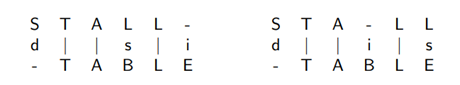

(d pour deletion, s pour substitution et i pour insertion)

Et d’autres moins bons :

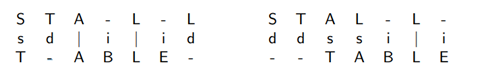

Pour trouver le bon alignement sans utiliser la force brute, on utilise la programmation dynamique. Ils existent beaucoup d’algorithme de programmation dynamiques : celui de Smith Waterman ou encore Needleman-Wunsch.

La distance minimum D(stall,table) doit être le minimum entre : 
- D(stall, tabl) + cost(insertion) 
- D(stal, table) + cost(deletion) 
- D(stal, tabl) + cost(substitution)


Les coûts peuvent être pris tous égaux (égaux à 1 par exemple) ou bien différents.

Le problème est de vouloir connaître les coûts de notre modèle de bruit qui nous permettent d’avoir le meilleur alignement possible.

Cependant, ces variables ne sont pas estimables si on ne connaît pas nos paramètres, ici les probabilités de réécriture de nos caractères.


L’algorithme EM (Expectation-Maximization) nous permet de résoudre ce genre de problème où on a alors des paramètres et des variables latentes.

Un schéma général de l’algorithme serait :

1)	Initialiser les coûts à 1

2)	Utiliser ces coûts pour calculer les valeurs optimales des variables.

3)	A partir des alignements précédents, recalculer les coûts optimaux.

4)	Répéter les étapes 2 et 3 jusqu’à ce que les paramètres ne changent plus.


Une autre mesure de similarité serait basée sur la distance d’un clavier d’ordinateur. 

On peut s’intéresser à la distance entre deux lettres sur un clavier azerty (ou qwerty selon la langue), et combiner ces distances en considérant que les erreurs de frappes sont indépendamment et identiquement distribuées. La distance entre deux mots sera alors le produit des distances entre leurs lettres. 

Cependant cela ne permet pas de prendre en compte insertions et suppressions. 

# Conclusion

La construction d’un correcteur de typos m’a permis de me renseigner sur beaucoup d’algorithmes surtout pour l’apprentissage non supervisé. N’ayant pas vraiment réussi à implémenter un modèle résistant au bruit, j’ai tout de même pu créer un correcteur de typos fonctionnel et imaginer plusieurs modèles permettant de gérer insertions, substitutions et suppressions.